In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from glob import glob
from PIL import Image
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
from natsort import natsorted
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(0, "../") 
import pickle

In [2]:
def bin_data(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])

def bin_data_mid(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])


def bin_data_range(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in ([f"[{int(x.left+1)}, {int(x.right+1)})"  for x in pd.cut(df[column], bins=bins).unique()]) ])


In [3]:
data = pd.read_pickle("cell_data.pickle").reset_index(drop=True)
data["Distance from centre of colony"] = np.sqrt(
    (data["Cell y"] - data["Colony centroid y"])**2 + (data["Cell x"] - data["Colony centroid x"])**2 
)
data["Normalised distance from centre of colony"] = data["Distance from centre of colony"] / (data["Colony diameter"]/2)
data["Mean true intensity"] = data["True intensity"] / data["Area"]
data["Mean observed intensity"] = data["Observed intensity"] / data["Area"]
data["Mean deconvolved intensity"] = data["Deconvolved intensity"] / data["Area"]
colony_groupby = data.groupby(["Wavelength", "Colony ID", "Colony N cells", "NA", "ni"])[["Mean true intensity", "Mean observed intensity", "Mean deconvolved intensity"]]
CVs = colony_groupby.std() / colony_groupby.mean()
CVs.columns = ["True CV", "Observed CV", "Deconvolved CV"]
CVs = CVs.reset_index()
data = pd.merge(data, CVs, on=["Colony ID", "Wavelength", "Colony N cells", "NA"])
data["Observed var"] = (data["Mean observed intensity"] * data["Observed CV"]) **2 
data["Observed cell intensity / True cell intensity (mean)"] = data["Mean observed intensity"] / data["Mean true intensity"]
data["Colony N cells (binned)"] = bin_data_range(bins = 3, df=data, column="Colony N cells", new_column_name="Colony N cells (binned)")
data["Normalised distance from centre of colony (binned)"] = bin_data(bins=10, df = data, column = "Normalised distance from centre of colony", new_column_name=None)
data["Colony N cells (fine-binned)"] = bin_data(bins = 15, df=data, column="Colony N cells", new_column_name="Colony N cells (fine-binned)")


data["Colony size"] = "Not assigned"
data.loc[data.eval("`Colony N cells` < 10"), "Colony size"] = "Small (<10 cells)"
data.loc[data.eval("`Colony N cells` > 200"), "Colony size"] = "Large (>200 cells)"


In [4]:
data.to_pickle("microcolony_plotting_data.pickle")

<AxesSubplot:xlabel='Colony N cells', ylabel='Mean observed intensity'>

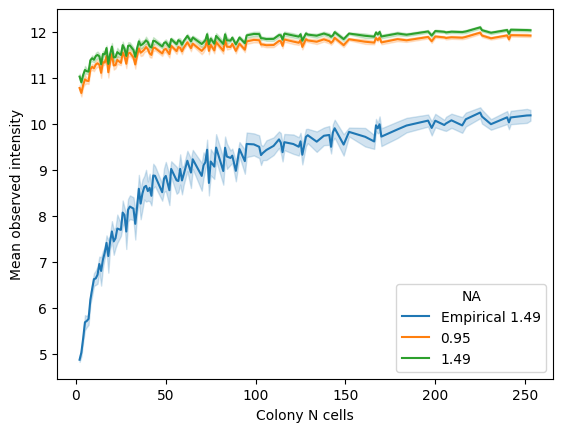

In [5]:
sns.lineplot(
    data = data.query("`True CV` < 0.05"),
    x = "Colony N cells",
    y = "Mean observed intensity",
    hue = "NA",
    errorbar=('ci', 99), 
)
#plt.ylim(0.5,1.2)

<AxesSubplot:xlabel='Colony N cells (fine-binned)', ylabel='Observed var'>

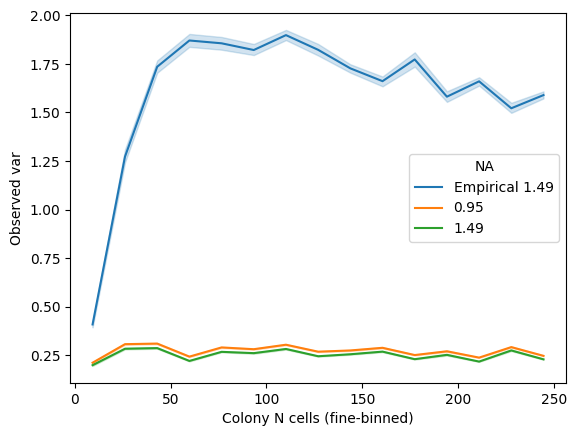

In [6]:
sns.lineplot(
    data = data.query("`True CV` < 0.05"),
    x = "Colony N cells (fine-binned)",
    y = "Observed var",
    hue = "NA",
    errorbar=('ci', 99), 
)
#plt.ylim(0.5,1.2)

<AxesSubplot:xlabel='Normalised distance from centre of colony (binned)', ylabel='Observed cell intensity / True cell intensity (mean)'>

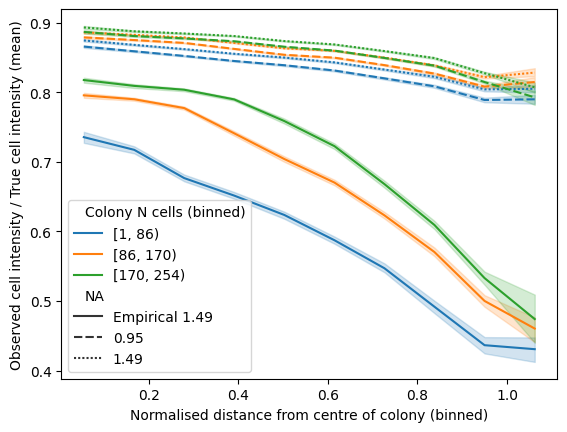

In [7]:
sns.lineplot(
    data = data.query("`Colony N cells` > 20 & `True CV` < 0.05"),
    x = "Normalised distance from centre of colony (binned)",
    y = "Observed cell intensity / True cell intensity (mean)",
    hue = "Colony N cells (binned)",
    errorbar=('ci', 99), 
    style="NA"
)
#plt.ylim(0.5,1.2)

<AxesSubplot:xlabel='Normalised distance from centre of colony (binned)', ylabel='Observed cell intensity / True cell intensity (mean)'>

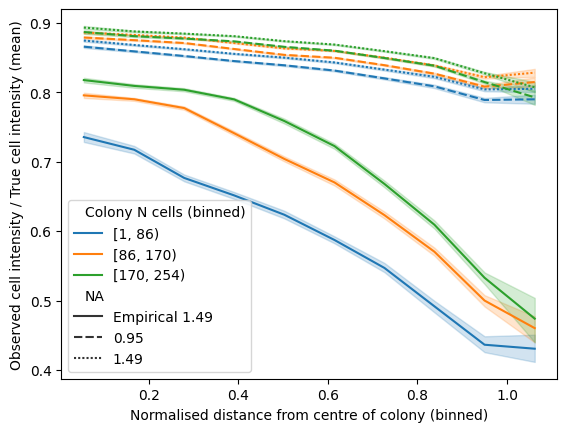

In [8]:
sns.lineplot(
    data = data.query("`Colony N cells` > 20 & `True CV` < 0.05"),
    x = "Normalised distance from centre of colony (binned)",
    y = "Observed cell intensity / True cell intensity (mean)",
    hue = "Colony N cells (binned)",
    errorbar=('ci', 99), 
    style="NA"
)


<AxesSubplot:xlabel='Normalised distance from centre of colony (binned)', ylabel='Mean observed intensity'>

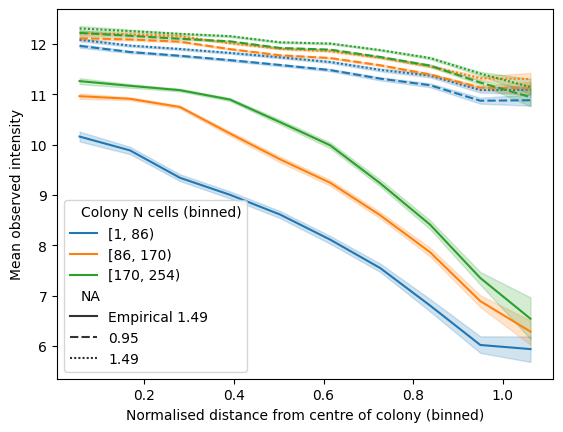

In [9]:
sns.lineplot(
    data = data.query("`Colony N cells` > 20 & `True CV` < 0.05"),
    x = "Normalised distance from centre of colony (binned)",
    y = "Mean observed intensity",
    hue = "Colony N cells (binned)",
    errorbar=('ci', 99), 
    style="NA"
)
#plt.ylim(0.5,1.2)

<AxesSubplot:xlabel='N neighbours', ylabel='Observed cell intensity / True cell intensity (mean)'>

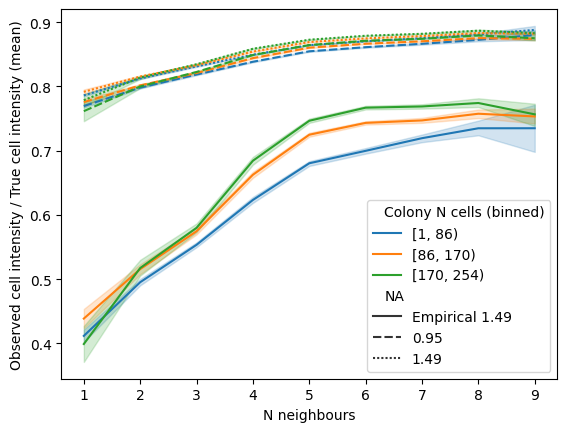

In [10]:
sns.lineplot(
    data = data.query("`Colony N cells` > 20 & `True CV` < 0.05"),
    x = "N neighbours",
    y = "Observed cell intensity / True cell intensity (mean)",
    hue = "Colony N cells (binned)",
    style="NA",
    #err_style="bars", 
    errorbar=('ci', 99), 
)
#plt.ylim(0.5,1.2)

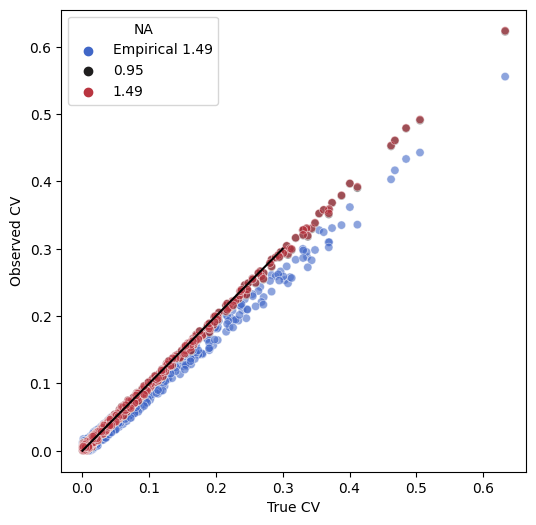

In [11]:
plt.figure(figsize=(6,6))
g = sns.scatterplot(
    data=data.drop_duplicates(["Colony ID", "NA","Wavelength"]).query("1 < `Colony N cells` < 3 & `Wavelength` == 0.55"), 
    x="True CV", 
    y = "Observed CV", 
    alpha=0.6, palette="icefire", hue = "NA"
    #err_style="bars", 
    #errorbar=('ci', 99), 
)

g.axes.plot([0,0.3],[0,0.3], c="k")
#plt.xlim(0,0.33)
#plt.ylim(0,0.33)
#plt.xscale("log")
#plt.yscale("log")
plt.show()

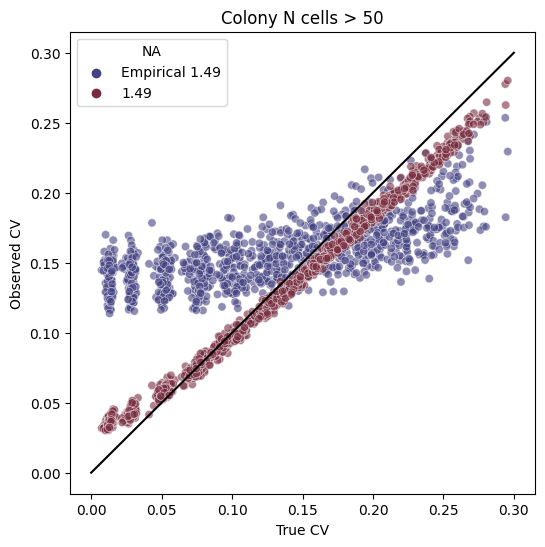

In [12]:
plt.figure(figsize=(6,6))
g = sns.scatterplot(
    data=data.drop_duplicates(["Colony ID", "NA","Wavelength"]).query("`Wavelength` == 0.55 & NA != 0.95 & `Colony N cells` > 50 "), 
    x="True CV", 
    y = "Observed CV", 
    alpha=0.6, palette="icefire", hue = "NA"
    #err_style="bars", 
    #errorbar=('ci', 99), 
)

g.axes.plot([0,0.3],[0,0.3], c="k")
#plt.xlim(0,0.33)
#plt.ylim(0,0.33)
#plt.xscale("log")
#plt.yscale("log")
plt.title("Colony N cells > 50")
plt.show()

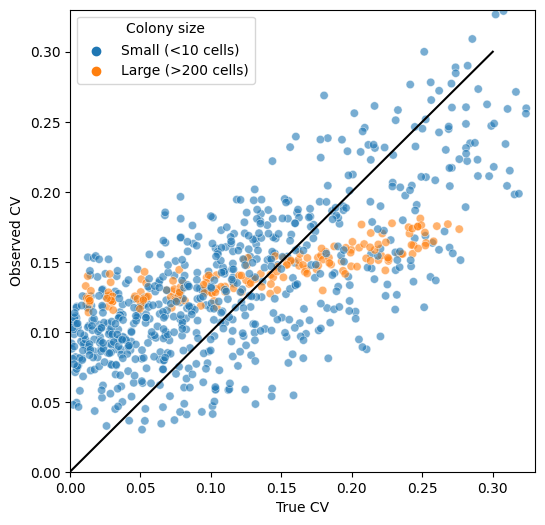

In [13]:
plt.figure(figsize=(6,6))
g = sns.scatterplot(
    data=data.drop_duplicates(["Colony ID", "NA","Wavelength"]).query("`Wavelength` == 0.55 & (NA != 0.95 and NA != 1.49) & ( (3 < `Colony N cells` < 10) or (200 < `Colony N cells`) )"), 
    x="True CV", 
    y = "Observed CV", 
    alpha=0.6, hue = "Colony size",
    #errorbar=('ci', 95), 
)

g.axes.plot([0,0.3],[0,0.3], c="k")
plt.xlim(0,0.33)
plt.ylim(0,0.33)
#plt.xscale("log")
#plt.yscale("log")
plt.show()

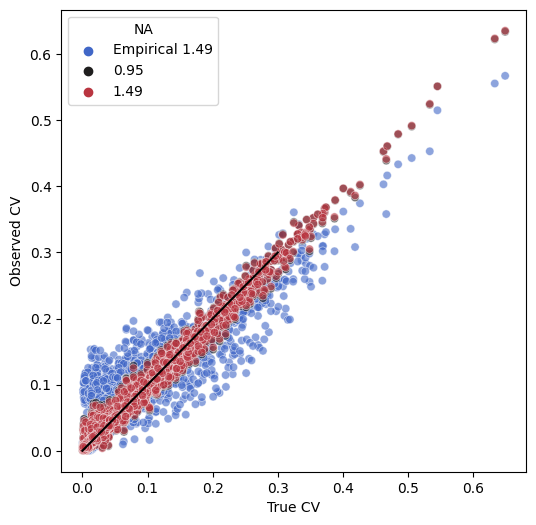

In [14]:
plt.figure(figsize=(6,6))
g = sns.scatterplot(
    data=data.drop_duplicates(["Colony ID", "NA","Wavelength"]).query("`Colony N cells` < 10 & `Wavelength` == 0.55"), 
    x="True CV", 
    y = "Observed CV", 
    alpha=0.6, palette="icefire", hue = "NA"
    #err_style="bars", 
    #errorbar=('ci', 99), 
)

g.axes.plot([0,0.3],[0,0.3], c="k")
#plt.xlim(0,0.33)
#plt.ylim(0,0.33)
#plt.xscale("log")
#plt.yscale("log")
plt.show()